<a href="https://colab.research.google.com/github/myngoc-trg/BERN04_ANN_DeepLearning/blob/main/Lab_1/BERN04_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>

# Introduction
## Short summary
In this exercise you will:

* train MLPs for simple classification and regression problems.
* learn how hyper-parameters such as learning rate, batch size and number of epochs affect training.

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report".

**Deadline for submitting the report: See Canvas assignment.**

## The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated using random numbers each time you run the cell. This means that each time you generate the data it will be slightly different. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
The *regr1* dataset represents a regression problem. It has one input and one target variable. It a cosine function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). The first 6 questions will use the *regr1* dataset and questions 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells.

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 2  | Init | Needed | Sets up the environment|
| 3  | Data | Needed | Defines the functions to generate the artificial datasets |
| 4  | PlotData | Information | Plots the 2D classification datasets |
| 5  | MLP | Needed | Defines the MLP model |
| 6  | Training | Needed | Functions for training and testing the MLP model |
| 7  | Boundary | Needed | Functions for showing classification boundaries and errors |
| 8  | Ex1 | Exercise | For question 1-4 |
| 9  | Ex2 | Exercise | For question 5-6 |
| 10 | Ex3 | Exercise | For question 7-8 |

To start with the exercise you need to run all cells with the celltype "Needed". The very first time we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work your way down the cells. Later, when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
The report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a short introduction to the content and purpose of the exercise.
* Answers to questions: For each of the questions provide an answer. It can be short answers or longer ones depending on the nature of the questions, but try to be efficient in your writing. (Don't include lots of program output or plots that aren't central to answering the question.)
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question!

## Last but not least
Have fun!

---

# CellName: Init (#2)
**CellType: Needed**  
**Cell instruction:**

In the cell below, we will import needed libraries.

Run the cell by entering into the cell and press "CTRL Enter".

In [1]:
import torch
device = 'cpu'
# Uncomment this to use CUDA acceleration if available
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"PyTorch: Using {device} device")
# The floating point data type can be changed here
dtype_torch = torch.float32

from torch.utils.data import DataLoader, TensorDataset
from torch import nn, Tensor
from collections import OrderedDict
!pip install torchmetrics
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np

PyTorch: Using cpu device
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.7 MB/s eta 0:00:00


# CellName: Data (#3)
**CellType: Needed**  
**Cell instruction:**

This cell defines the two synthetic datasets. The last function is used for standardization of the data.

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def syn2(N):
    "Generate data for a classification problem in 2D."
    x = np.empty(shape=(N, 2))
    d = np.empty(shape=(N, 1))
    N1 = N // 2

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(size=(N1, 2))
    # Negative samples
    x[N1:,:] = -.8 + np.random.normal(size=(N-N1, 2))

    # Target
    d[:N1] = 1
    d[N1:] = 0

    return x, d

def regr1(N, periods=2, damp=False, v=0):
    "Generate data for 1D regression problem with damped cosine and noise"
    dx = 2*periods*np.pi / (N-1)
    x = np.arange(N) * dx

    if damp:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    noise = lambda n : np.random.normal(size=n)
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)

    return x[:, None], d[:, None]

def standard(x):
    "Mean and stddev across samples"
    return np.mean(x, axis=0), np.std(x, axis=0)

# CellName: PlotData (#4)
**CellType: Information**  
**Cell instruction:**

Here, we generate 100 cases for *syn2* and *regr1* datasets and plot them.

Run the cell by entering into the cell and press "CTRL Enter".

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

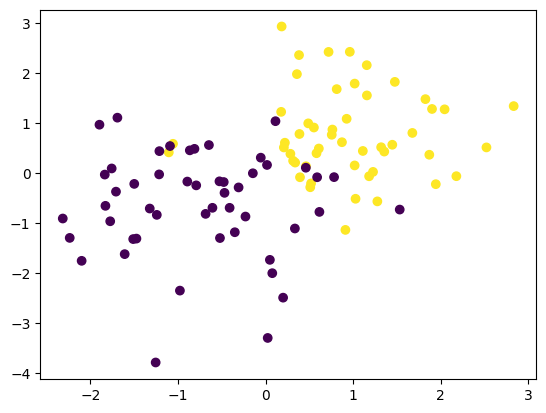

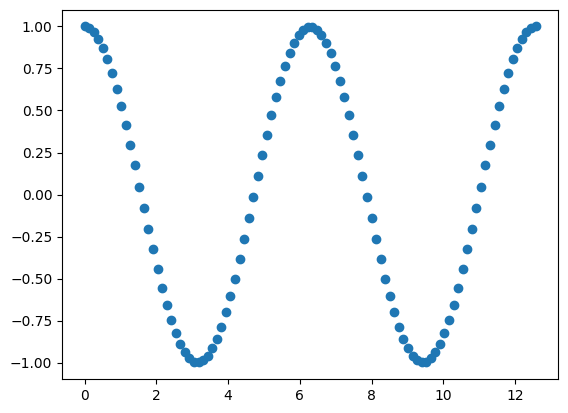

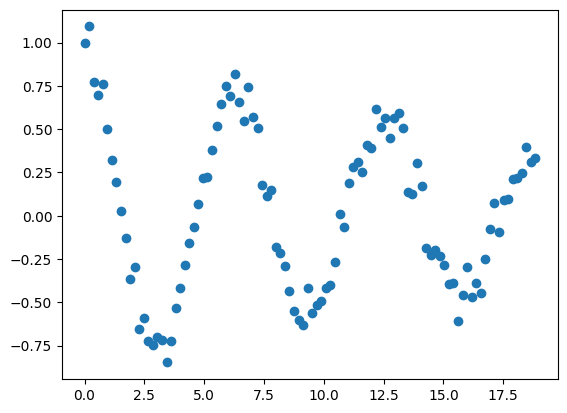

In [3]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x, d = syn2(100)
plt.figure()
plt.scatter(x[:,0], x[:,1], c=d)

# Regression, one period, no noise
x, d = regr1(100, 2, False, 0)
plt.figure()
plt.scatter(x, d)

# Regression, 1.5 period, exponential damping, some noise
x, d = regr1(100, 3, True, 0.2)
plt.figure()
plt.scatter(x, d)

# CellName: MLP (#5)
**CellType: Needed**  
**Cell instruction:**

This cell defines the MLP model. Several MLP hyperparameters are needed to define a model.
Here is a list of them:  
(**Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.)

* inputs: the input dimension (integer)

* output: the input dimension (integer)

* nodes: size of the network, eg `[5]` for a one hidden layer with 5 nodes and `[5, 3]` for a two layer network with 5 and 3 hidden nodes each.

* activation: the activation function. Most common are
    * `nn.ReLU`
    * `nn.Tanh`
        
* output_activation: the activation function for the output nodes. Most common are
    * `None` (linear activation)
    * `nn.Sigmoid`
    * `nn.Softmax`
      
Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
class Network(nn.Module):
    "A simple MLP with one or more fully connected layers"

    def __init__(self, *, inputs=1, outputs=1, nodes=[4], activation=nn.Tanh, out_activation=None):
        """
        Args:
            inputs (int, optional): The number of input nodes.
            outputs (int, optional): The number of output nodes.
            nodes (list, optional): A list of layer sizes.
            activation: Activation function (or None for linear). Defaults to nn.Tanh
            out_activation (optional): Activation function for output layer.
        """
        super().__init__()

        seqstack = OrderedDict()
        prevn = inputs
        for i, n in enumerate(nodes):
            seqstack[f"layer{i+1}"] = nn.Linear(prevn, n, dtype=dtype_torch)
            prevn = n
            if activation is not None:
                seqstack[f"act{i+1}"] = activation()
        seqstack["layerN"] = nn.Linear(prevn, outputs, dtype=dtype_torch)
        if out_activation is not None:
            seqstack["actN"] = out_activation()
        self.mlp_stack = nn.Sequential(seqstack)

    def forward(self, x : Tensor):
        "Apply the network stack on some input"
        return self.mlp_stack(x)

    def predict(self, input_data):
        """
        Apply the network on a set of input data.

        Args:
            input_data (np.ndarray): Input data

        Returns:
            pred (np.ndarray): Predicted output.
        """
        self.eval()
        inp = torch.tensor(input_data, dtype=dtype_torch, device=device)
        with torch.no_grad():
            pred = self(inp)
        return pred.cpu().numpy()

    def __str__(self):
        s = super().__str__()
        ps = ["Named parameters:"] + [
            f"{name}: {param.numel()}" for name, param in
             self.mlp_stack.named_parameters() if param.requires_grad]
        totp = sum(p.numel() for p in self.mlp_stack.parameters() if p.requires_grad)
        return s + f"\nTrainable parameters: {totp}\n" + "\n  ".join(ps) + "\n"

# CellName: Training (#6)
**CellType: Needed**  
**Cell Instruction:**

This cell defines functions for training the model for a single epoch (`train_epoch`),
evaluating the performance in the validation data (`test`) and training and validating over
many epochs (`train_loop`). Finally, it defines a function (`plot_training`) for plotting
the training progress.

The `train_loop` function takes a previously defined `Network` model, two PyTorch `DataLoader`s
that provide the data for training and test, and several hyperparameters:

* loss_fn: The error function used during training. There are three common ones
    * `nn.MSELoss` (mean squared error)
    * `nn.BCELoss` (binary cross entropy)
    * `nn.CrossEntropyLoss` (categorical cross entropy)

* optimizer: The error minimization method, which is constructed with information about the model and a learning rate. Common choices are
    * `torch.optim.SGD`
    * `torch.optim.Adam`

* metrics: Additional metrics to compute and print besides the loss. We use the [torcheval.metrics package](https://docs.pytorch.org/torcheval/main/torcheval.metrics.html) and pass the metric(s) as a dict with `{name: metric}`. Examples:
    * `{'accuracy': ptmetrics.BinaryAccuracy()}`
    * `{'MSE': ptmetrics.MeanSquaredError()}`

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def train_epoch(*, model : Network, dataloader : DataLoader,
                loss_fn, optimizer : torch.optim.Optimizer):
    """
    Train a model for a single epoch.

    Args:
        model (Network): The network.
        dataloader (DataLoader): Batch DataLoader with training data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): The optimizer used to update the network.

    Returns:
        train_loss (float): Training error over all batches.
    """
    model.train()
    train_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)   # Move data to GPU if necessary
        optimizer.zero_grad()   # Reset the gradients

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(X)

        # Backpropagation
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader.dataset)

def test(*, model : Network, dataloader : DataLoader, loss_fn, metrics=[]):
    """
    Test a model on a set of data.

    Args:
        model (Network): The network.
        dataloader (DataLoader): DataLoader with data to test.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        metrics (iterable): Additional metrics from torchmetrics.

    Returns:
        loss (float): Mean error over all batches.
    """
    model.eval()
    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item() * len(X)
            for m in metrics:
                m.update(pred, y)
    return loss / len(dataloader.dataset)


def train_loop(*, model : Network, train_dataloader : DataLoader,
               val_dataloader : DataLoader = None, loss_fn,
               optimizer : torch.optim.Optimizer, epochs : int,
               print_every:int = 100, metrics=None, print_final=True):
    """
    Train and optionally test a model.

    Args:
        model (Network): The network.
        train_dataloader (DataLoader): Training data.
        val_dataloader (DataLoader, optional): Validation data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): An optimizer from torch.optim.
        epochs (int): Number of epochs to train for.
        print_every (int, optional): Print loss every so many epochs. Defaults to 100.
        metrics (dict(name: metric), optional): Record/print these additional metrics.
        print_final(bool, optional): Print final metrics. Defaults to True.

    Returns:
        train_losses (list(float)): Training loss during each epoch.
        val_losses (list(float)): Validation loss after each epoch.
        metrics_res (dict(name: list(float))): Values of metrics after each epoch.
    """
    train_losses = []
    val_losses = []
    val_loss = np.nan

    # Move metrics to CPU/GPU and prepare for their output
    metrics = {name: m.to(device) for name, m in (metrics or {}).items()}
    metrics_res = {name: [] for name in metrics.keys()}

    for t in range(epochs):
        train_loss = train_epoch(model=model, dataloader=train_dataloader,
                           loss_fn=loss_fn, optimizer=optimizer)
        train_losses.append(train_loss)
        if val_dataloader is not None:
            for m in metrics.values():
                m.reset()
            val_loss = test(dataloader=val_dataloader, model=model,
                            loss_fn=loss_fn, metrics=metrics.values())
            val_losses.append(val_loss)
            for name, m in metrics.items():
                metrics_res[name].append(m.compute().cpu())
        if (print_every > 0 and t % print_every == 0) or (
                print_every >= 0 and t + 1 == epochs):
            extras = [f" {n} {v[-1]:<7f}" if torch.isreal(v[-1])
                      else f" {n} {v[-1]}"
                      for n, v in metrics_res.items()]
            print(f"Epoch {t+1:<7d} train {train_loss:<7f} "
                  f" validation {val_loss:<7f}", "".join(extras))
    if print_final:
        print("\n** Validation metrics after training **\n"
              f"Loss {val_losses[-1]:<7g}")
        for n, v in metrics_res.items():
            if torch.isreal(v[-1]):
                print(f"{n} {v[-1]:<7g}")
            else:
                print(f"{n}:")
                print(v[-1])
        print()
    return train_losses, val_losses, metrics_res

def plot_training(train_loss, val_loss, metrics_res={}):
    "Plot the training history"
    plt.figure()
    plt.ylabel('Loss / Metric')
    plt.xlabel('Epoch')
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    for name, res in metrics_res.items():
        if torch.isreal(res[0]):
            plt.plot(res, label=name)
    plt.legend(loc='best')
    plt.show()

# CellName: Boundary (#7)
**CellType: Needed**  
**Cell Instruction:**

This cell defines a function for presenting the output of binary MLP classifiers, plotting the decision boundary for a problem with 2D input. In brief, this function defines a grid that covers the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary.

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def decision_boundary(X : np.ndarray, Y1 : np.ndarray, model):
    """
        Plot classfication and decision boundary for binary classification problem

        Args:
            X (np.ndarray): input
            Y1 (np.ndarray): target
            model (Network): the model

        Returns:
            None.
    """
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z[Z > .5] = 1
    Z[Z <= .5] = 0

    Y_pr = model.predict(X).flatten()
    Y = Y1.flatten()

    Y_pr[Y_pr > .5] = 1
    Y_pr[Y_pr <= .5] = 0
    Y[(Y != Y_pr) & (Y == 0)] = 2
    Y[(Y != Y_pr) & (Y == 1)] = 3

    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], marker='+', c='k')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], marker='o', c='k')

    plt.scatter(X[Y == 3, 0], X[Y == 3, 1], marker = '+', c='r')
    plt.scatter(X[Y == 2, 0], X[Y == 2, 1], marker = 'o', c='r')

    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()

---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

# CellName: Ex1 (#8)
**CellType: Exercise**  
**Cell instruction:**

Questions 1-4 look at three essential parameters that controls the training process of an MLP: the *learning rate*, *batch size* and *number of epochs* (or epochs for short). By training process we mean here the minimization of the given loss function. The task is to train an MLP with four hidden nodes that can fit the *regr1* dataset. In this version of the dataset, there is no noise. Therefore, we need not specify any seed.

The dataset and network have been selected so that it is possible, but not trivial, to get a good training result.
A successful training means here when the networks has reached a loss < 0.01, and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

## Question 1, variations in pre-defined MLP
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If not, **why?** **(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?**

## Question 2, vary learning rate
You will now study what happens when you train with different learning rates. Test at least 5 different learning rates in the range from 0.001 to 0.5. For each learning rate train the network three times and record the average MSE value over these three runs. **Present your average MSE results and discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. The learning rate is best investigated with (roughly) proportional changes rather than constant steps: For example, trying 0.5, 0.2, 0.1, 0.05, 0.02 etc. typically gives more interesting results than 0.5, 0.4, 0.3, 0.2, 0.1.

## Question 3, vary (mini)batch size
We now (hopefully) have discovered that the learning rate influences the efficiency of the loss minimization. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a "batch size" that is smaller the the size of the training data. (We now adapt to the language of ANN packages such as PyTorch and use the word "batch" where most literature would use "mini-batch".) Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Present and discuss your findings**.

**Note:** The batch size should (fairly well) divide the total data size. With a data size of 50, good batch sizes are 50, 25, 13, 10, 5... Sizes that fit poorly, like 40, create a small last batch which could give you the disadvantages of both small and large batch sizes at the same time.

## Question 4, select good hyper-parameters
Find a combination of learning rate and batch size that gives a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* of the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size, and its result**.

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.956335  validation 0.805501  MSE 0.805501
Epoch 101     train 0.501565  validation 0.501537  MSE 0.501537
Epoch 201     train 0.498815  validation 0.498787  MSE 0.498787
Epoch 301     train 0.496134  validation 0.496108  MSE 0.496108
Epoch 401     train 0.493543  validation 0.493518  MSE 0.493518
Epoch 501     train 0.491058  validation 0.491033  MSE 0.491033
Epoch 601     train 0.488666  validation 0.488643  MSE 0.488643
Epoch 701     train 0.486332  validation 0.486309  MSE 0.486309
Epoch 801     train 0.484004  validation 0.483981  MSE 0.483981
Epoch 901     train 0.481625  validation 0.481601  MSE 0.481601
Epoch 1001    train 0.479143  validation 0.479118  MSE 0.

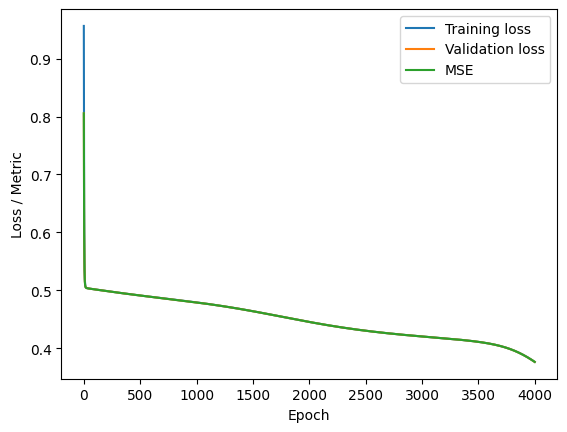

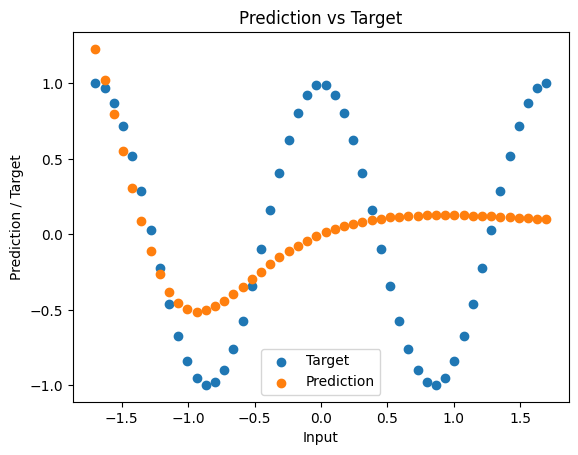

CPU times: user 9.58 s, sys: 39.4 ms, total: 9.62 s
Wall time: 12.2 s


In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex1 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[4],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.05          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Print a summary of the model
print(model_ex1)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex1.predict(x_trn)

# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

# CellName: Ex2 (#9)
**CellType: Exercise**  
**Cell instruction:**  

The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will highlight this.

## Question 5, vary epochs
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**. Note, you may need to vary the number of epochs a lot! If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

## Question 6, vary network size and other hyper-parameters
Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper-parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). To create many hidden layers, add many numbers to the `layers` list, for example: `layers = [10, 5, 5]`. **Present your set of good hyper-parameters and the result**.

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


# CellName: Ex3 (#10)
**CellType: Exercise**  
**Cell instruction:**  

We will now look at the classification problem defined by the *syn2* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code.

## Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers).
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0.

## Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there are modifications of SGD that are very popular, e.g. Adam.
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**

**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999.

## Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**.

The tasks listed below also mean that you have to change the code in code cell *Training* (#6). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. PyTorch has methods that can lower the learning rate as we train (see [here](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). Again go back to Q7 and now use an exponentially decaying learning rate (`ExponentialLR`). **Does it help?**



## Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers).
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=32, out_features=16, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=16, out_features=8, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=8, out_features=1, bias=True)
    (actN): Sigmoid()
  )
)
Trainable parameters: 2945
Named parameters:
  layer1.weight: 128
  layer1.bias: 64
  layer2.weight: 2048
  layer2.bias: 32
  layer3.weight: 512
  layer3.bias: 16
  layer4.weight: 128
  layer4.bias: 8
  layerN.weight: 8
  layerN.bias: 1

Epoch 1       train 0.687334  validation 0.660994  accuracy 0.540000
Epoch 101     train 0.186686  validation 0.171616  accuracy 0.940000
Epoch 201     train 0.158734  validation 0.148054  accuracy 0.940000
Epoch 301     train 0.138266  validation 0.131904  accuracy 0.950000
Epoch 401     train 0.122

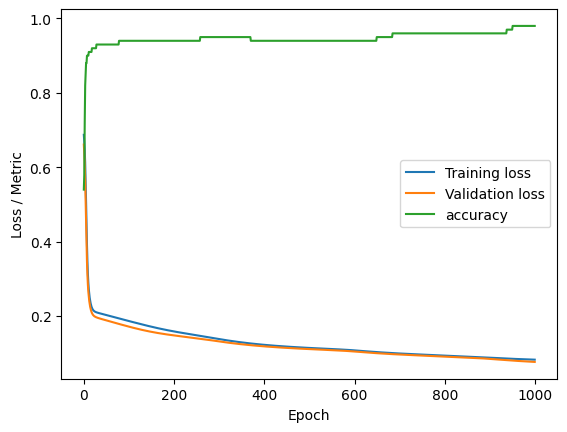

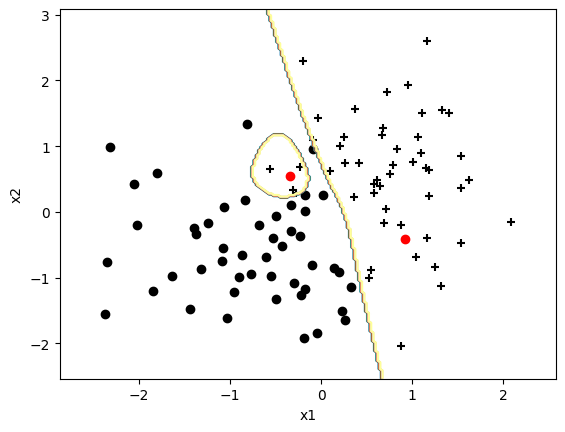

CPU times: user 11.6 s, sys: 29 ms, total: 11.6 s
Wall time: 11.7 s


In [26]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 1234
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex3 = Network(
    inputs=x_trn.shape[1],      # number of input nodes
    outputs=1,                  # number of output nodes
    nodes=[64,32,16,8],                 # number of nodes in hidden layer
    activation=nn.Tanh,         # activation function in hidden layer
    out_activation=nn.Sigmoid   # activation function in output layer
    ).to(device)                # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD    # minimization method
learning_rate = 0.1             # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 1000
minibatch_size = 32

# Additional metrics to print
metrics = { 'accuracy': torchmetrics.Accuracy('binary') }

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex3.predict(x_trn)

# Plot the decision boundary
decision_boundary(x_trn, d_trn, model_ex3)

## Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there are modifications of SGD that are very popular, e.g. Adam.
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**

**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999.


Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=32, out_features=16, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=16, out_features=8, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=8, out_features=1, bias=True)
    (actN): Sigmoid()
  )
)
Trainable parameters: 2945
Named parameters:
  layer1.weight: 128
  layer1.bias: 64
  layer2.weight: 2048
  layer2.bias: 32
  layer3.weight: 512
  layer3.bias: 16
  layer4.weight: 128
  layer4.bias: 8
  layerN.weight: 8
  layerN.bias: 1

Epoch 1       train 0.695842  validation 0.507828  accuracy 0.920000
Epoch 101     train 0.102980  validation 0.101635  accuracy 0.960000
Epoch 201     train 0.044759  validation 0.044705  accuracy 0.980000
Epoch 301     train 0.040236  validation 0.040170  accuracy 0.980000
Epoch 401     train 0.052

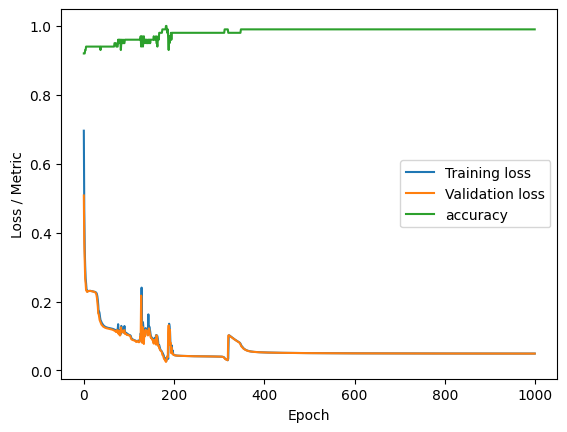

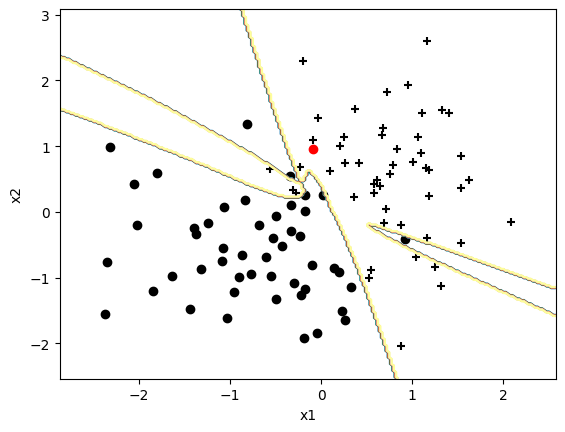

CPU times: user 15.1 s, sys: 39 ms, total: 15.2 s
Wall time: 15.3 s


In [27]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 1234
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex3 = Network(
    inputs=x_trn.shape[1],      # number of input nodes
    outputs=1,                  # number of output nodes
    nodes=[64,32,16,8],                 # number of nodes in hidden layer
    activation=nn.Tanh,         # activation function in hidden layer
    out_activation=nn.Sigmoid   # activation function in output layer
    ).to(device)                # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.Adam    # minimization method
learning_rate = 0.01             # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 1000
minibatch_size = 32

# Additional metrics to print
metrics = { 'accuracy': torchmetrics.Accuracy('binary') }

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex3.predict(x_trn)

# Plot the decision boundary
decision_boundary(x_trn, d_trn, model_ex3)

# The report!

<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>

## NANCY TRUONG

## Introduction
In this lab report, we will:


*   build and train MLPs to solve basic classification and regression tasks.
*   explore how different hyper-parameters, such as learning rate, batch size, and the number of training epochs, impact the performance of model.

We will use two synthetic different data sets in this exercise syn2 and regr1.








Note: If you cannot solve this task in *reasonable* time, present your best attempt!

**Question 7**, optimize hyper-parameters for classification  
Present your set of hyper-parameters that reach > 95% accuracy

**Question 8**, change learning algorithm  
Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them. Present changes you needed to make to improve the results of the Adam optimizer, if any.

**Bonus tasks** (if you feel inspired)

## Summary
Connect the summary to your introduction, to provide a brief overview of your findings.
  


##**Question 1**, variations in pre-defined MLP  
**(a)** Do you see the same loss vs epoch behavior each time your run? If not, why?

The loss per epoch behavior is not the same for each run. This is because we initialize a new model each time, so the starting weights differ. Depending on the initial weights, the training may converge quickly to a global minimum, or it may get stuck in a local minimum, resulting in slower convergence or higher final loss.

**(b)** Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?

Yes, training can fail in the sense that some runs do not reach a very slow loss. While the training loss generally decreases over epochs, certain initializations lead to slower reductions, and the model may converge to supoptimal minima rather than the glonbal minima.

##**Question 2**, vary learning rate  
We trained the network with five different learning rates: 0.001, 0.005, 0.01, 0.02, and 0.05. For each learning rate, the network was trained three times, and the average MSE was recorded.

In [29]:
# Modify plot_training function for my use

def plot_training(train_loss, val_loss, metrics_res={}, ax=None):
    '''Plot the training history

    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates a new figure.
    '''
    if ax is None:
      fig, ax = plt.subplots()

    #plt.figure()
    ax.set_ylabel('Loss / Metric')
    ax.set_xlabel('Epoch')
    ax.plot(train_loss, label="Training loss")
    ax.plot(val_loss, label="Validation loss")
    for name, res in metrics_res.items():
        if torch.isreal(res[0]):
            ax.plot(res, label=name) # Changed plt.plot to ax.plot
    ax.legend(loc='best')
    if ax is None:
      plt.show()


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.526880  validation 0.526808  MSE 0.526808
Epoch 1001    train 0.508420  validation 0.508415  MSE 0.508415
Epoch 2001    train 0.505797  validation 0.505796  MSE 0.505796
Epoch 3001    train 0.504434  validation 0.504433  MSE 0.504433
Epoch 4000    train 0.503239  validation 0.503238  MSE 0.503238

** Validation metrics after training **
Loss 0.503238
MSE 0.503238



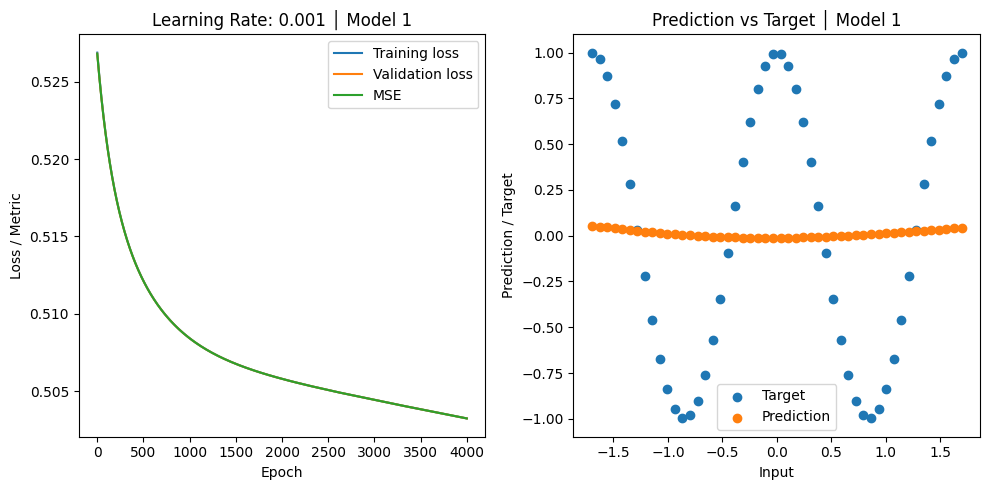


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 1.073828  validation 1.069802  MSE 1.069802
Epoch 1001    train 0.510187  validation 0.510177  MSE 0.510177
Epoch 2001    train 0.506815  validation 0.506814  MSE 0.506814
Epoch 3001    train 0.505940  validation 0.505939  MSE 0.505939
Epoch 4000    train 0.505378  validation 0.505378  MSE 0.505378

** Validation metrics after training **
Loss 0.505378
MSE 0.505378



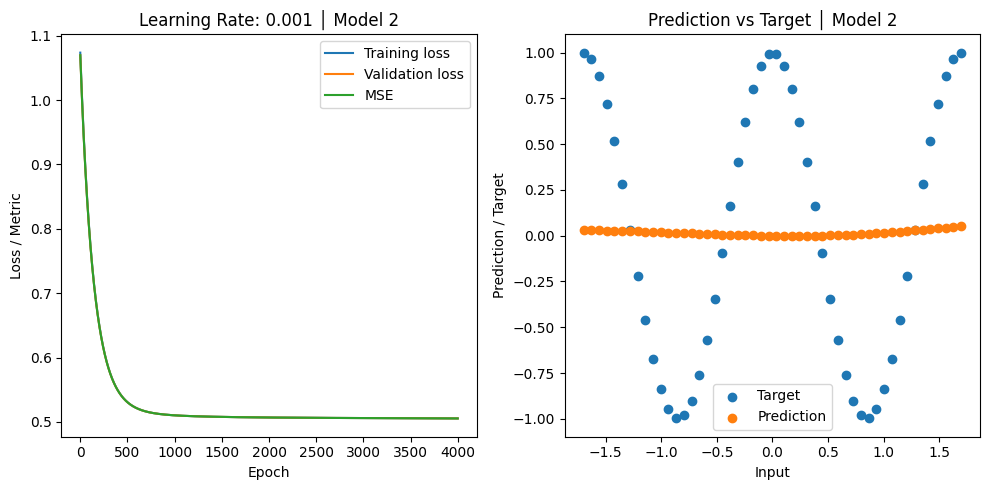


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.675693  validation 0.675090  MSE 0.675090
Epoch 1001    train 0.523546  validation 0.523518  MSE 0.523518
Epoch 2001    train 0.511869  validation 0.511865  MSE 0.511865
Epoch 3001    train 0.510300  validation 0.510299  MSE 0.510299
Epoch 4000    train 0.510058  validation 0.510058  MSE 0.510058

** Validation metrics after training **
Loss 0.510058
MSE 0.510058



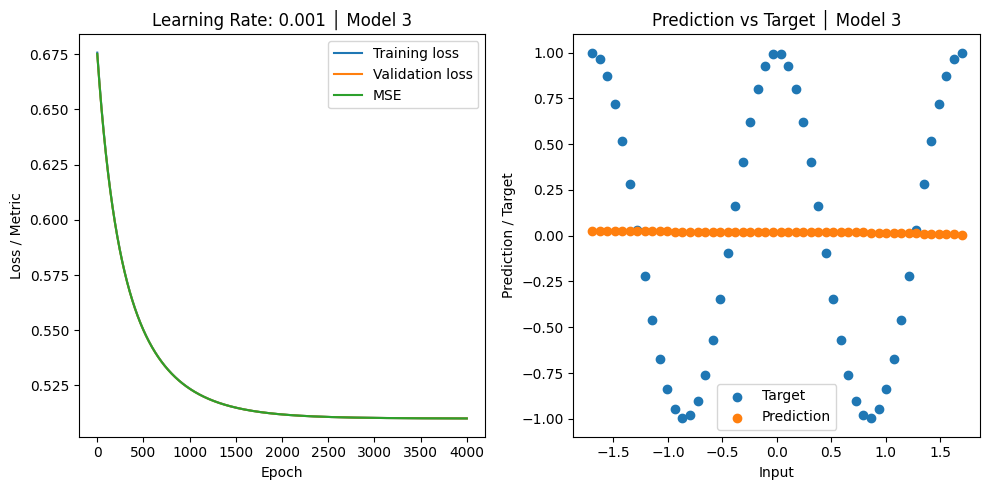


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 1.058088  validation 1.039493  MSE 1.039493
Epoch 1001    train 0.507869  validation 0.507866  MSE 0.507866
Epoch 2001    train 0.505562  validation 0.505559  MSE 0.505559
Epoch 3001    train 0.503147  validation 0.503145  MSE 0.503145
Epoch 4000    train 0.500540  validation 0.500538  MSE 0.500538

** Validation metrics after training **
Loss 0.500538
MSE 0.500538



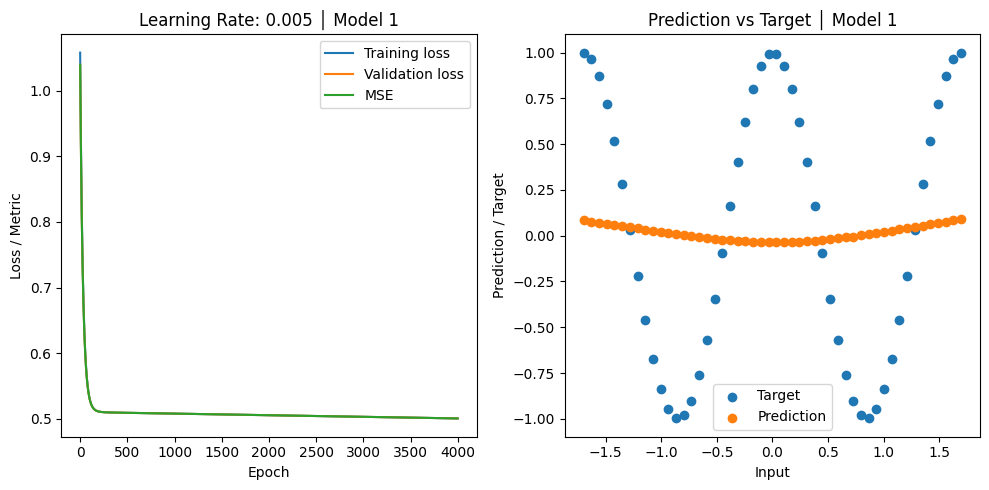


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.679431  validation 0.675071  MSE 0.675071
Epoch 1001    train 0.498245  validation 0.498241  MSE 0.498241
Epoch 2001    train 0.494914  validation 0.494910  MSE 0.494910
Epoch 3001    train 0.491923  validation 0.491920  MSE 0.491920
Epoch 4000    train 0.489129  validation 0.489127  MSE 0.489127

** Validation metrics after training **
Loss 0.489127
MSE 0.489127



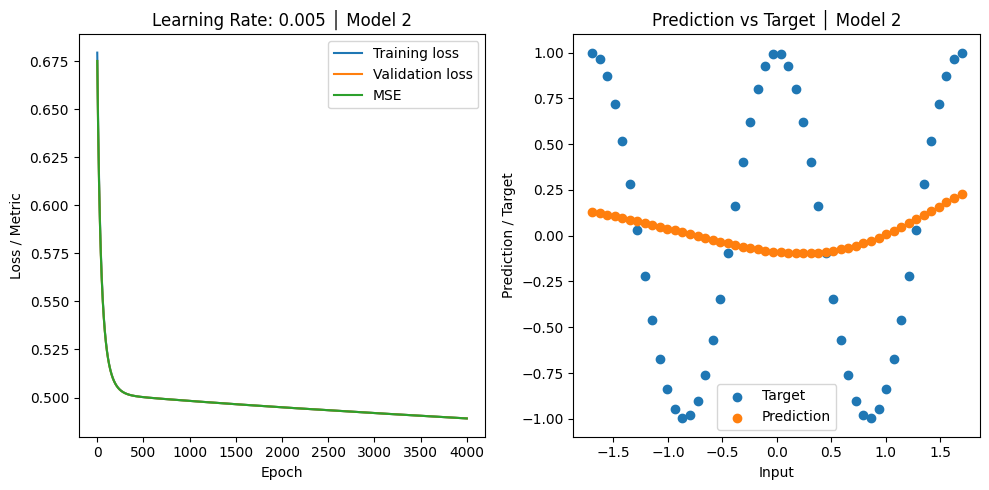


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.866319  validation 0.854997  MSE 0.854997
Epoch 1001    train 0.497522  validation 0.497518  MSE 0.497518
Epoch 2001    train 0.493508  validation 0.493504  MSE 0.493504
Epoch 3001    train 0.490229  validation 0.490226  MSE 0.490226
Epoch 4000    train 0.487407  validation 0.487404  MSE 0.487404

** Validation metrics after training **
Loss 0.487404
MSE 0.487404



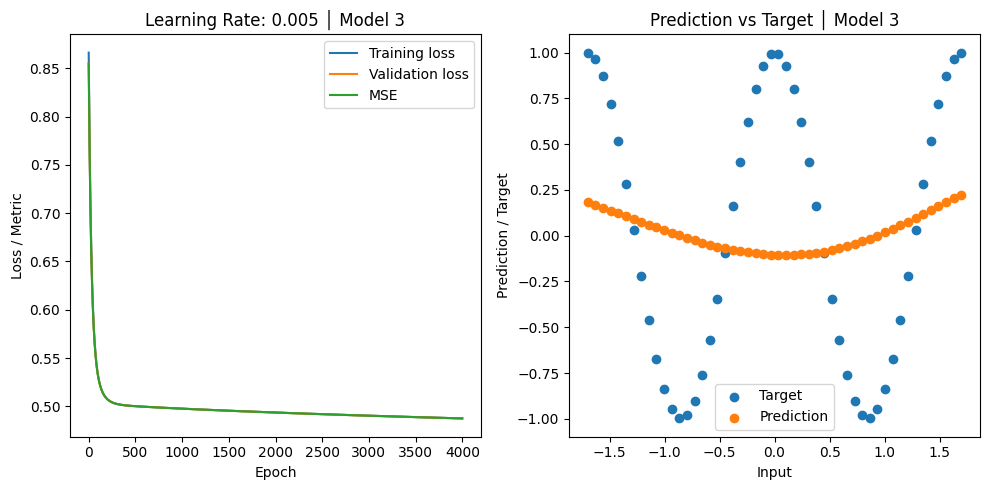


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.738901  validation 0.725765  MSE 0.725765
Epoch 1001    train 0.507672  validation 0.507666  MSE 0.507666
Epoch 2001    train 0.503085  validation 0.503081  MSE 0.503081
Epoch 3001    train 0.499021  validation 0.499017  MSE 0.499017
Epoch 4000    train 0.494769  validation 0.494765  MSE 0.494765

** Validation metrics after training **
Loss 0.494765
MSE 0.494765



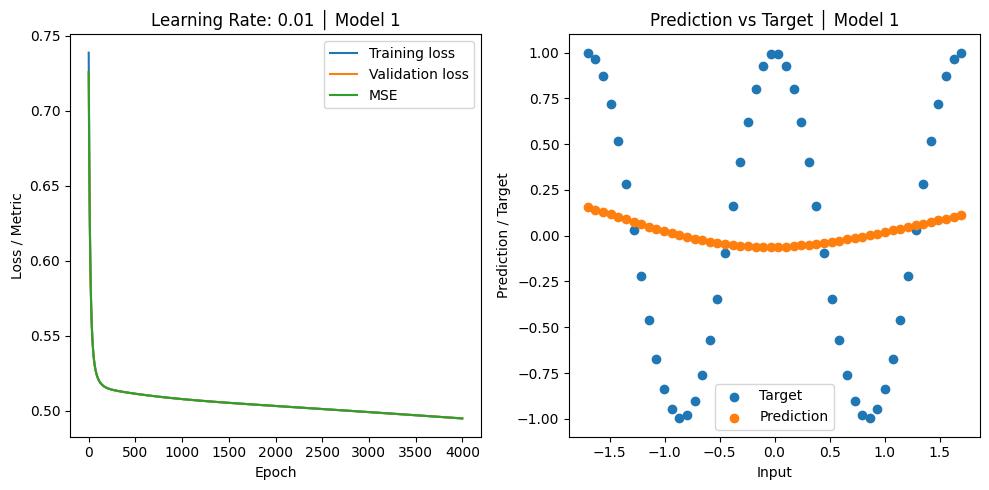


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.777072  validation 0.751611  MSE 0.751611
Epoch 1001    train 0.503487  validation 0.503478  MSE 0.503478
Epoch 2001    train 0.495479  validation 0.495472  MSE 0.495472
Epoch 3001    train 0.489350  validation 0.489344  MSE 0.489344
Epoch 4000    train 0.484632  validation 0.484627  MSE 0.484627

** Validation metrics after training **
Loss 0.484627
MSE 0.484627



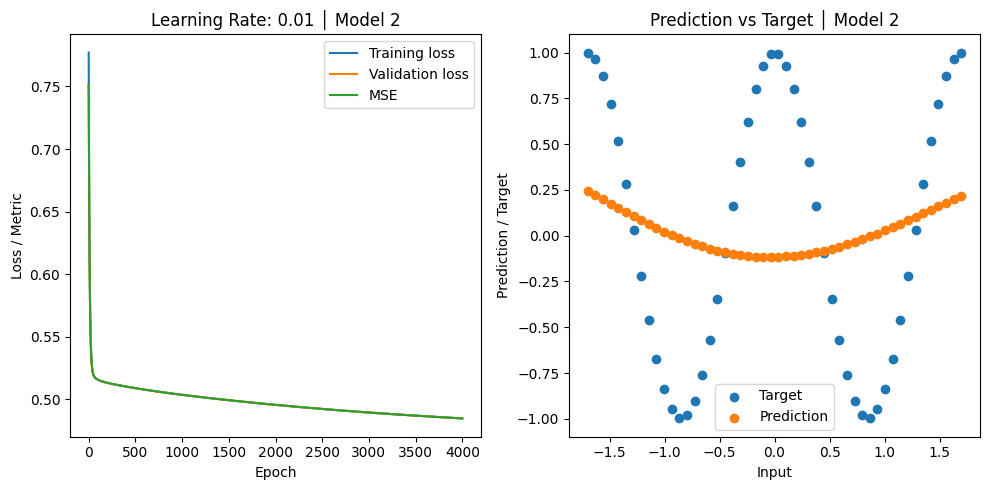


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.547684  validation 0.544576  MSE 0.544576
Epoch 1001    train 0.507068  validation 0.507064  MSE 0.507064
Epoch 2001    train 0.501987  validation 0.501981  MSE 0.501981
Epoch 3001    train 0.495372  validation 0.495366  MSE 0.495366
Epoch 4000    train 0.490056  validation 0.490052  MSE 0.490052

** Validation metrics after training **
Loss 0.490052
MSE 0.490052



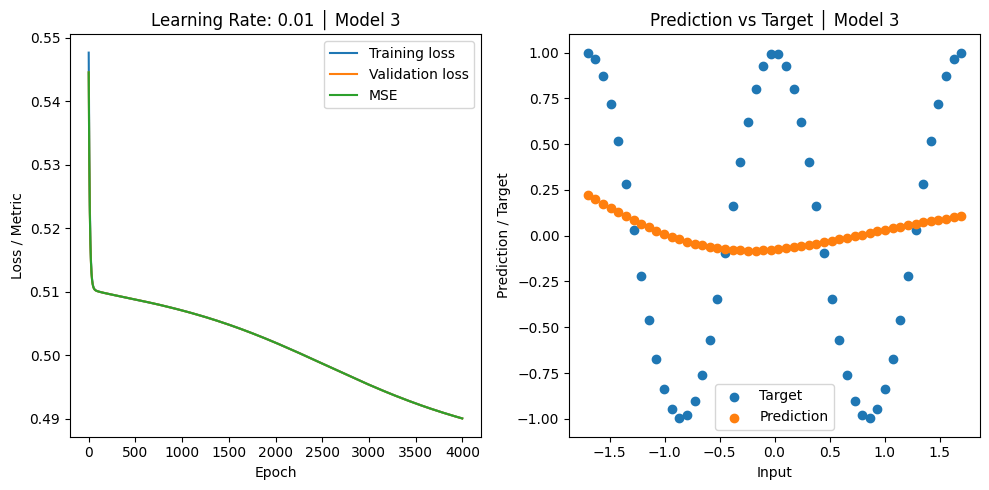


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.871268  validation 0.828819  MSE 0.828819
Epoch 1001    train 0.506070  validation 0.506063  MSE 0.506063
Epoch 2001    train 0.493932  validation 0.493918  MSE 0.493918
Epoch 3001    train 0.485159  validation 0.485152  MSE 0.485152
Epoch 4000    train 0.478986  validation 0.478980  MSE 0.478980

** Validation metrics after training **
Loss 0.47898
MSE 0.47898



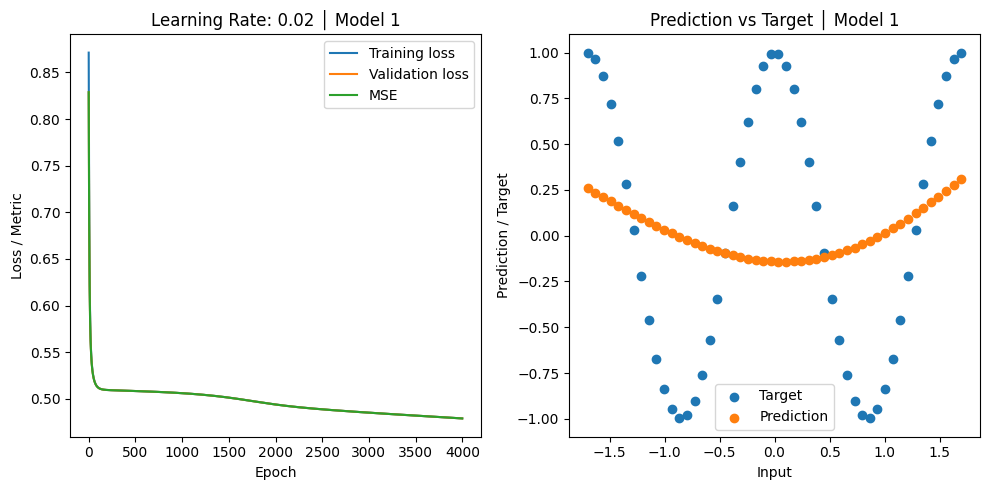


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.657313  validation 0.639749  MSE 0.639749
Epoch 1001    train 0.489171  validation 0.489158  MSE 0.489158
Epoch 2001    train 0.477858  validation 0.477847  MSE 0.477847
Epoch 3001    train 0.465219  validation 0.465205  MSE 0.465205
Epoch 4000    train 0.450615  validation 0.450600  MSE 0.450600

** Validation metrics after training **
Loss 0.4506 
MSE 0.4506 



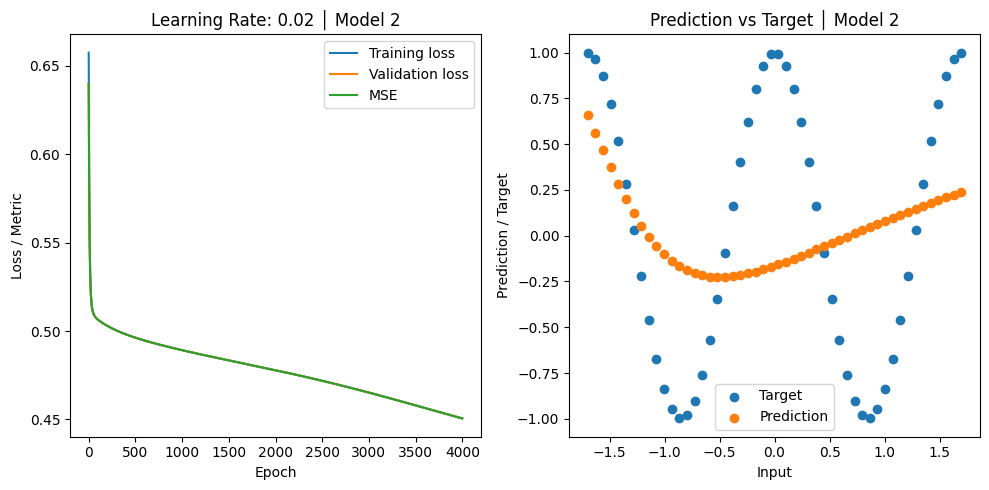


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.729696  validation 0.705619  MSE 0.705619
Epoch 1001    train 0.493220  validation 0.493203  MSE 0.493203
Epoch 2001    train 0.474098  validation 0.474064  MSE 0.474064
Epoch 3001    train 0.384385  validation 0.384235  MSE 0.384235
Epoch 4000    train 0.226740  validation 0.226558  MSE 0.226558

** Validation metrics after training **
Loss 0.226558
MSE 0.226558



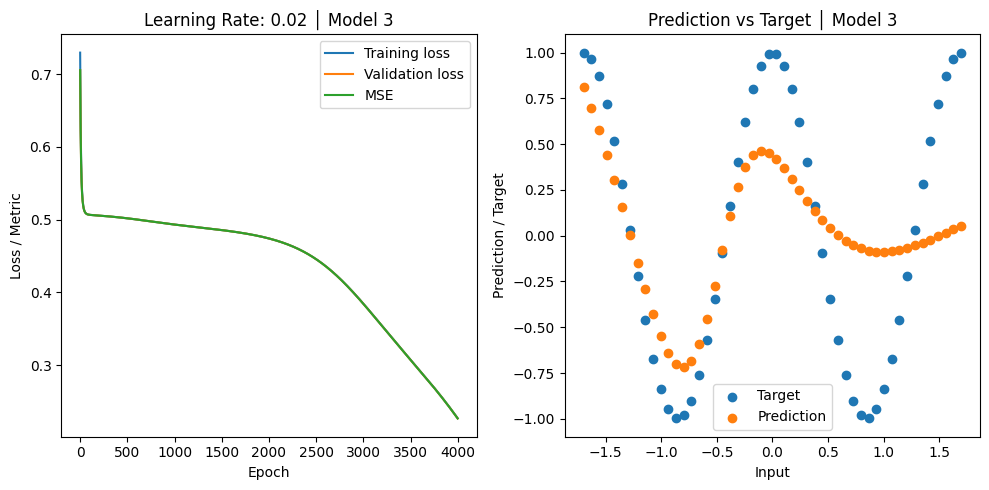


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.662611  validation 0.635405  MSE 0.635405
Epoch 1001    train 0.413376  validation 0.413041  MSE 0.413041
Epoch 2001    train 0.099229  validation 0.098894  MSE 0.098894
Epoch 3001    train 0.005928  validation 0.005919  MSE 0.005919
Epoch 4000    train 0.002590  validation 0.002589  MSE 0.002589

** Validation metrics after training **
Loss 0.00258906
MSE 0.00258906



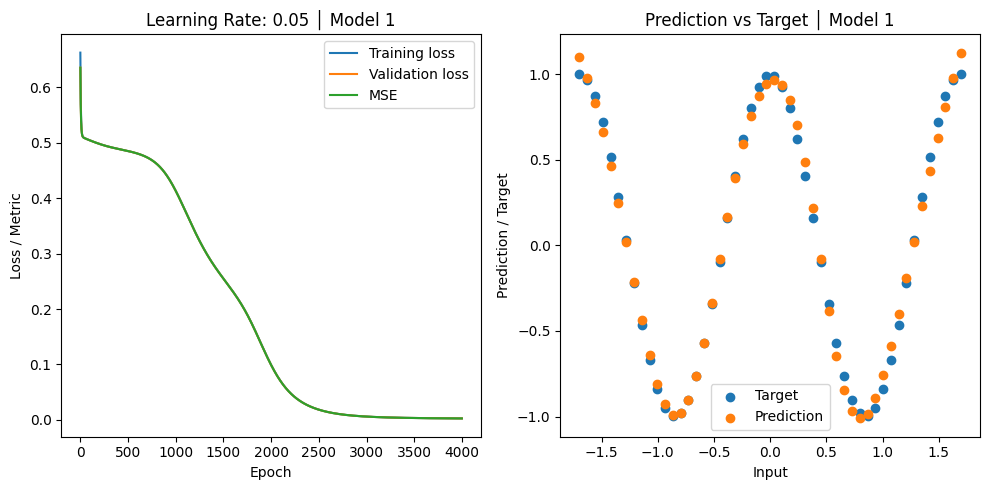


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.669637  validation 0.619416  MSE 0.619416
Epoch 1001    train 0.480001  validation 0.479975  MSE 0.479975
Epoch 2001    train 0.448878  validation 0.448844  MSE 0.448844
Epoch 3001    train 0.417239  validation 0.417186  MSE 0.417186
Epoch 4000    train 0.184311  validation 0.183946  MSE 0.183946

** Validation metrics after training **
Loss 0.183946
MSE 0.183946



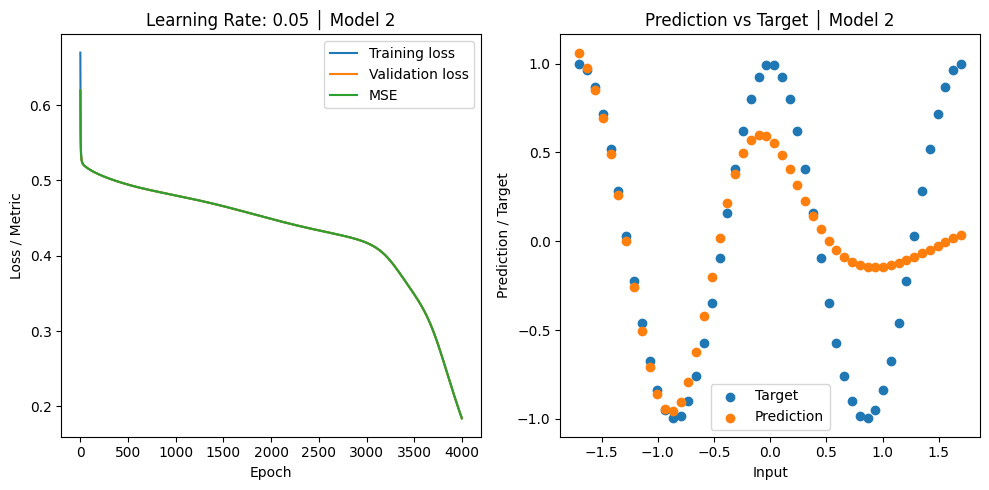


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.593374  validation 0.573496  MSE 0.573496
Epoch 1001    train 0.389733  validation 0.389285  MSE 0.389285
Epoch 2001    train 0.024776  validation 0.024714  MSE 0.024714
Epoch 3001    train 0.005017  validation 0.005012  MSE 0.005012
Epoch 4000    train 0.002779  validation 0.002779  MSE 0.002779

** Validation metrics after training **
Loss 0.00277851
MSE 0.00277851



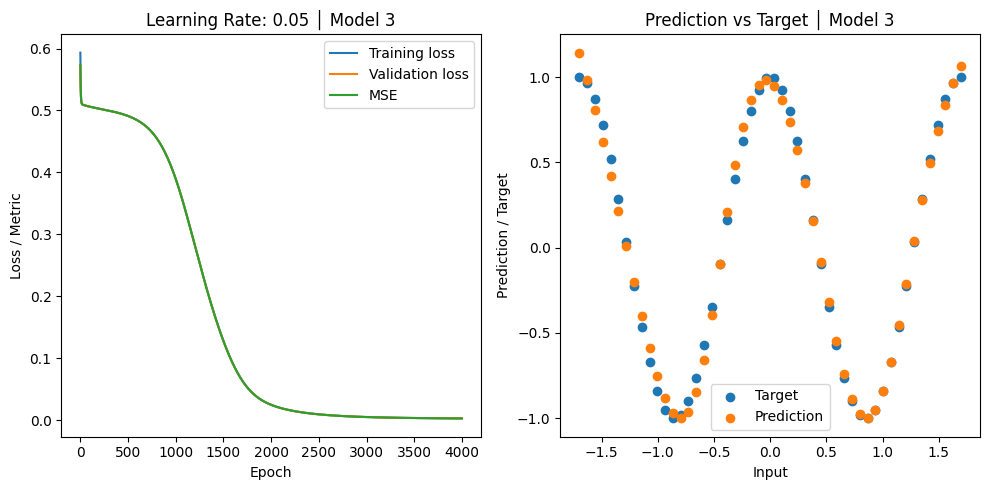

CPU times: user 2min 28s, sys: 212 ms, total: 2min 28s
Wall time: 2min 30s


In [30]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std


# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate_lists = [0.001,0.005,0.01,0.02,0.05]          # 5 different learning rates
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Initialized List of MSEs to Records of metrics
MSEs_lr = []


# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                        torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

for learning_rate in learning_rate_lists:
  # Define the network, cost function and training settings
  # Initialized List of MSEs to Records of metrics of three runs with the same lr
  MSEs = []
  for i in range(3):
    model_ex1 = Network(
        inputs=1,            # number of input nodes
        outputs=1,           # number of output nodes
        nodes=[4],           # number of nodes in hidden layer
        activation=nn.Tanh,  # activation function in hidden layer
        out_activation=None  # activation function in output layer (if not linear)
        ).to(device)         # move data to GPU or keep with CPU

    # Set up the optimizer
    optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

    # Print a summary of the model
    print(f"\n--- Training with Learning Rate: {learning_rate} ---")
    print(model_ex1)


    # Train the network and print the progress
    train_loss, val_loss, metrics_res = train_loop(
        model=model_ex1,
        train_dataloader=dl_trn,
        val_dataloader=dl_trn, # Test with the training data
        loss_fn=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        print_every=1000,
        epochs=number_epochs)

    # Record performance metrics for MSEs list
    for n, v in metrics_res.items():
      if torch.isreal(v[-1]):
          #print(f"{n} {v[-1]:<7g}; Type: {type(v[-1])}")
          MSEs.append(v[-1])



    # Predict output on the training data
    d_pred = model_ex1.predict(x_trn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(f"Learning Rate: {learning_rate} │ Model {i+1}")
    plot_training(train_loss, val_loss, metrics_res, ax = ax[0])

    ax[1].set_ylabel('Prediction / Target')
    ax[1].set_xlabel('Input')
    ax[1].scatter(x_trn, d_trn, label='Target')
    ax[1].scatter(x_trn, d_pred, label='Prediction')
    ax[1].set_title(f'Prediction vs Target │ Model {i+1}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

  MSEs_lr.append(np.mean([m.item() for m in MSEs])) # Use .item() to get scalar value from tensor

In [31]:
for lr in learning_rate_lists:
  print(f"Average MSE for learning rate {lr}: {MSEs_lr[learning_rate_lists.index(lr)]:.4f}")


Average MSE for learning rate 0.001: 0.5062
Average MSE for learning rate 0.005: 0.4924
Average MSE for learning rate 0.01: 0.4898
Average MSE for learning rate 0.02: 0.3854
Average MSE for learning rate 0.05: 0.0631


### Observation for **Question 2**

A very low learning rate (0.001 and 0.005) leads to very slow convergence. The network takes many epochs to reduce the loss, which can result in insufficient training and sometimes getting stuck in local minima.

Moderate learning rates (0.01 and 0.02) do not improve performance. Ocassionally, with a lucky initial weight initialization, 0.02 can reach slightly better loss values, but overall, the improvements is marginal.

The highest tested learning rate (0.05) consistenly achieved the lowest average MSE and fastest convergence, meaning that for this problem, SGD with batch update benefits from a relatively higher learning rate.


### Discussion for **Question 2**

The effectiveness of a learning rate also depends on the initial weights: good initializations allow the network to reach lower loss even with moderate learning rates.

Too small a learning rate slows training and risks getting stuck in plateau or shallow regions of the loss landscape.

Larger rates can accelerate learning and help escape local minima, but if increases too much, may destabilize training.

Therefore, for this regression task, a higher learning rate like 0.05 provides the best balance of convergence and final performance. Mediym rates like 0.02 can sometimes be competitive with favorable initial weights but are less reliable.

##**Question 3**, vary (mini)batch size  
We fixed the learning rate at 0.05 and tested different batch sizes: 1, 5, 10, 25 and 50. For each batch size, we trained three networks and recorded the training was sucessful (MSE < 0.01) and approximately how many epochs were needed to each a good solution.


--- Training with Batch Size: 1 & Model 1 ---
Epoch 1       train 0.241854  validation 0.731844  MSE 0.731844
Epoch 1001    train 0.000550  validation 0.000645  MSE 0.000645
Epoch 2001    train 0.000218  validation 0.000192  MSE 0.000192
Epoch 3001    train 0.000174  validation 0.000150  MSE 0.000150
Epoch 4000    train 0.000172  validation 0.000150  MSE 0.000150

** Validation metrics after training **
Loss 0.000150238
MSE 0.000150238

MSE 0.000150238)
Sucessful traing!!!


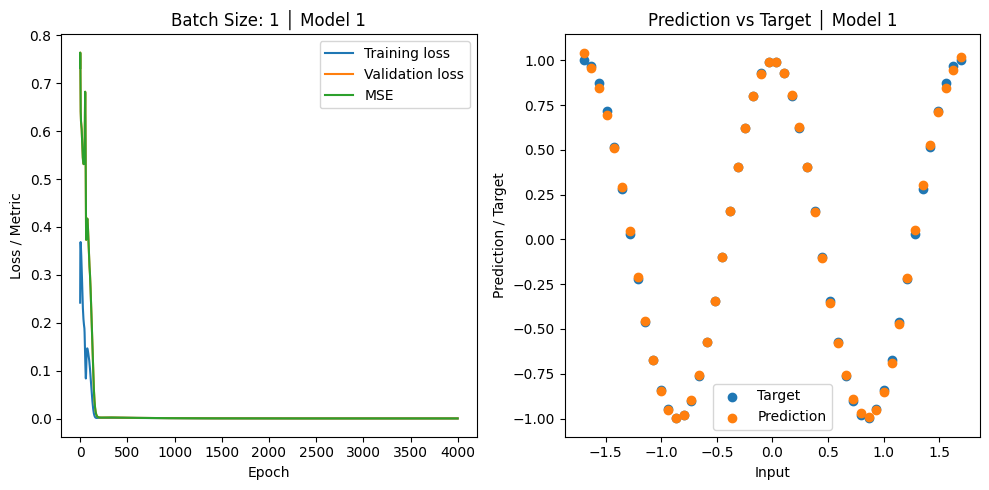


--- Training with Batch Size: 1 & Model 2 ---
Epoch 1       train 0.305036  validation 0.691006  MSE 0.691006
Epoch 1001    train 0.456499  validation 0.569881  MSE 0.569881
Epoch 2001    train 0.456500  validation 0.569880  MSE 0.569880
Epoch 3001    train 0.456500  validation 0.569880  MSE 0.569880
Epoch 4000    train 0.456500  validation 0.569880  MSE 0.569880

** Validation metrics after training **
Loss 0.56988
MSE 0.56988

MSE 0.56988)


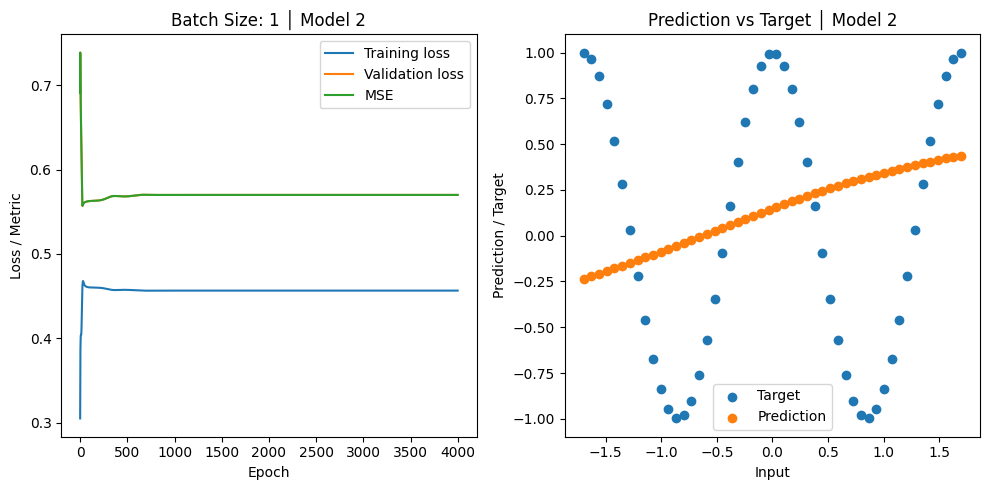


--- Training with Batch Size: 1 & Model 3 ---
Epoch 1       train 0.254342  validation 0.895292  MSE 0.895292
Epoch 1001    train 0.000572  validation 0.000711  MSE 0.000711
Epoch 2001    train 0.000199  validation 0.000187  MSE 0.000187
Epoch 3001    train 0.000157  validation 0.000144  MSE 0.000144
Epoch 4000    train 0.000158  validation 0.000146  MSE 0.000146

** Validation metrics after training **
Loss 0.000146455
MSE 0.000146455

MSE 0.000146455)
Sucessful traing!!!


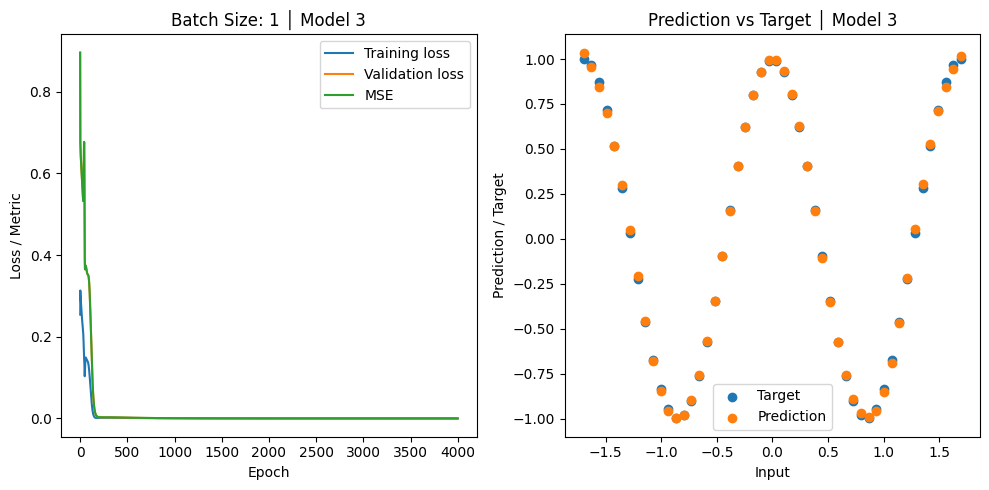


--- Training with Batch Size: 5 & Model 1 ---
Epoch 1       train 0.619689  validation 0.508473  MSE 0.508474
Epoch 1001    train 0.387326  validation 0.312024  MSE 0.312024
Epoch 2001    train 0.330502  validation 0.262538  MSE 0.262538
Epoch 3001    train 0.002006  validation 0.001681  MSE 0.001681
Epoch 4000    train 0.000848  validation 0.000764  MSE 0.000764

** Validation metrics after training **
Loss 0.000764119
MSE 0.000764119

MSE 0.000764119)
Sucessful traing!!!


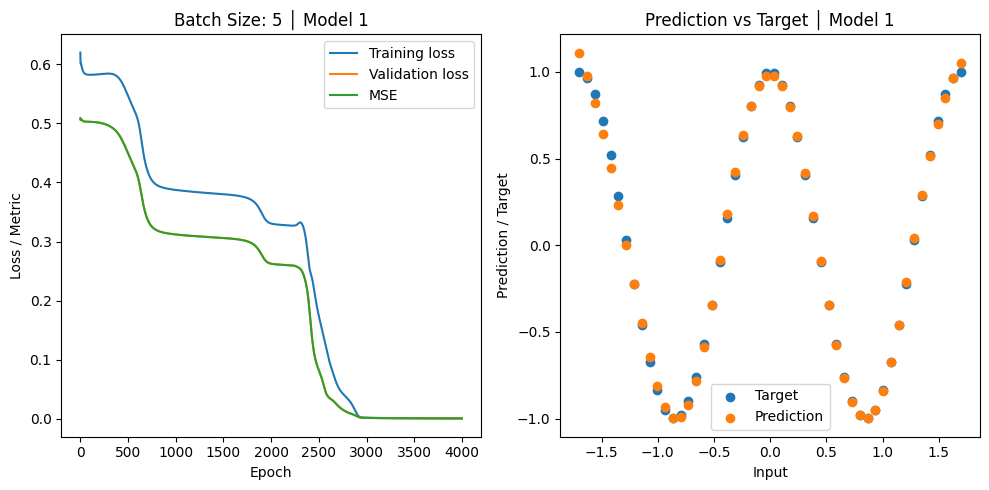


--- Training with Batch Size: 5 & Model 2 ---
Epoch 1       train 0.778662  validation 0.557685  MSE 0.557685
Epoch 1001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 2001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 3001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 4000    train 0.555451  validation 0.509655  MSE 0.509655

** Validation metrics after training **
Loss 0.509655
MSE 0.509655

MSE 0.509655)


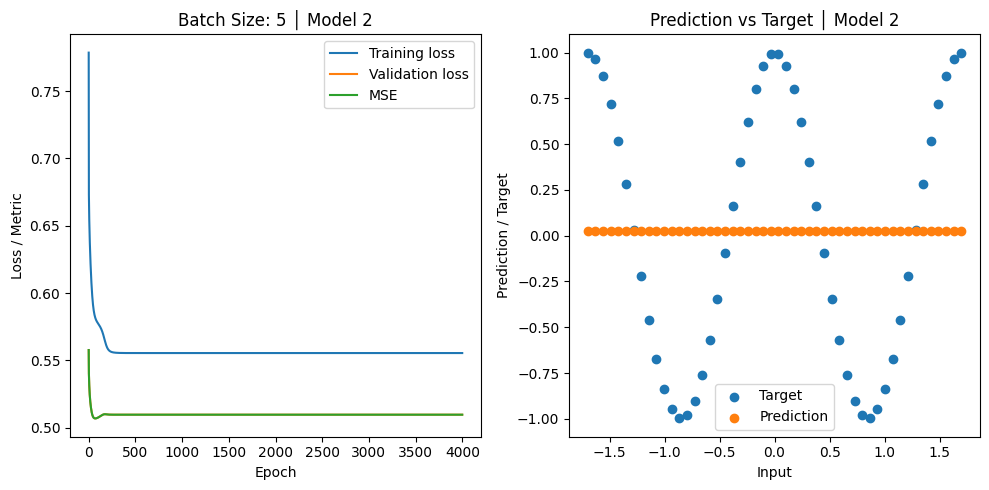


--- Training with Batch Size: 5 & Model 3 ---
Epoch 1       train 0.751683  validation 0.573987  MSE 0.573987
Epoch 1001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 2001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 3001    train 0.555451  validation 0.509655  MSE 0.509655
Epoch 4000    train 0.555451  validation 0.509655  MSE 0.509655

** Validation metrics after training **
Loss 0.509655
MSE 0.509655

MSE 0.509655)


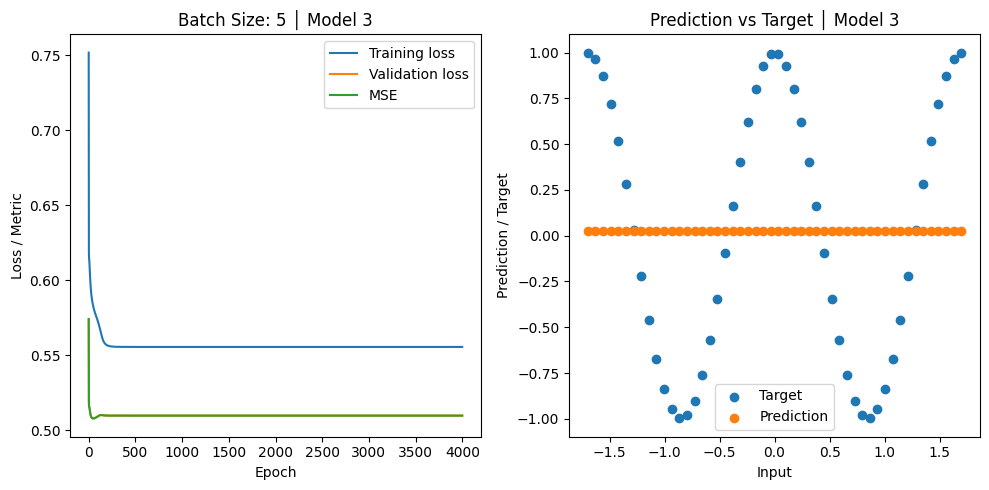


--- Training with Batch Size: 10 & Model 1 ---
Epoch 1       train 0.661866  validation 0.524092  MSE 0.524092
Epoch 1001    train 0.001790  validation 0.001766  MSE 0.001766
Epoch 2001    train 0.001174  validation 0.001165  MSE 0.001165
Epoch 3001    train 0.000898  validation 0.000893  MSE 0.000893
Epoch 4000    train 0.000737  validation 0.000734  MSE 0.000734

** Validation metrics after training **
Loss 0.000733817
MSE 0.000733817

MSE 0.000733817)
Sucessful traing!!!


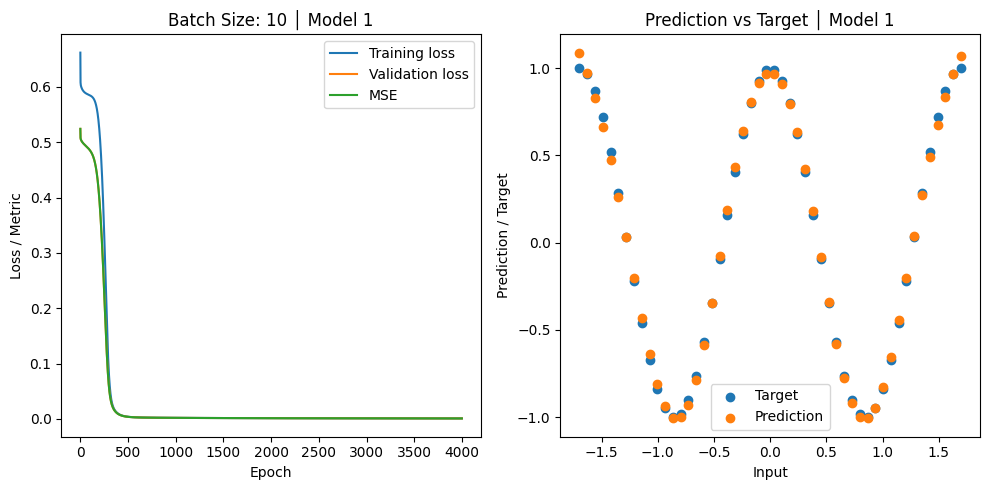


--- Training with Batch Size: 10 & Model 2 ---
Epoch 1       train 0.725883  validation 0.507784  MSE 0.507784
Epoch 1001    train 0.002127  validation 0.002110  MSE 0.002110
Epoch 2001    train 0.001530  validation 0.001522  MSE 0.001522
Epoch 3001    train 0.001216  validation 0.001211  MSE 0.001211
Epoch 4000    train 0.001009  validation 0.001004  MSE 0.001004

** Validation metrics after training **
Loss 0.00100443
MSE 0.00100443

MSE 0.00100443)
Sucessful traing!!!


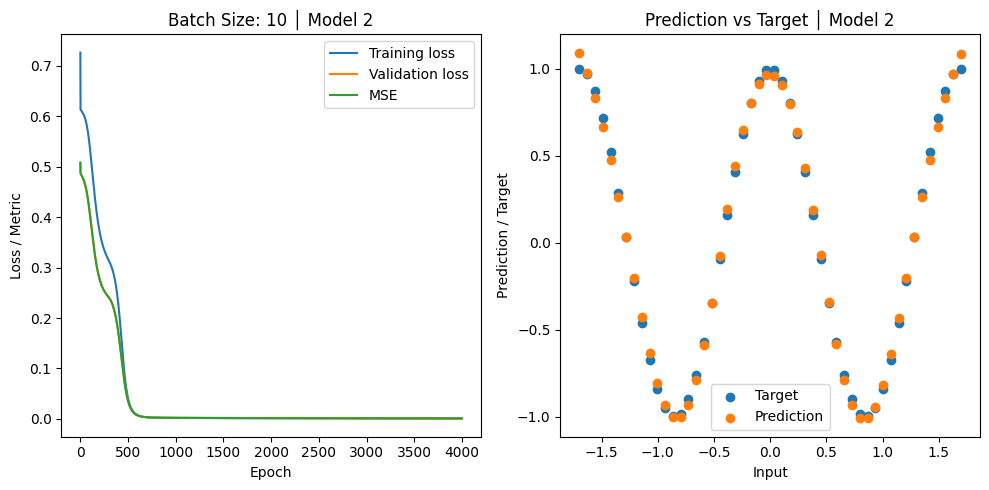


--- Training with Batch Size: 10 & Model 3 ---
Epoch 1       train 0.741629  validation 0.515151  MSE 0.515151
Epoch 1001    train 0.491273  validation 0.416036  MSE 0.416036
Epoch 2001    train 0.482063  validation 0.407719  MSE 0.407719
Epoch 3001    train 0.478502  validation 0.404521  MSE 0.404521
Epoch 4000    train 0.476769  validation 0.402949  MSE 0.402949

** Validation metrics after training **
Loss 0.402949
MSE 0.402949

MSE 0.402949)


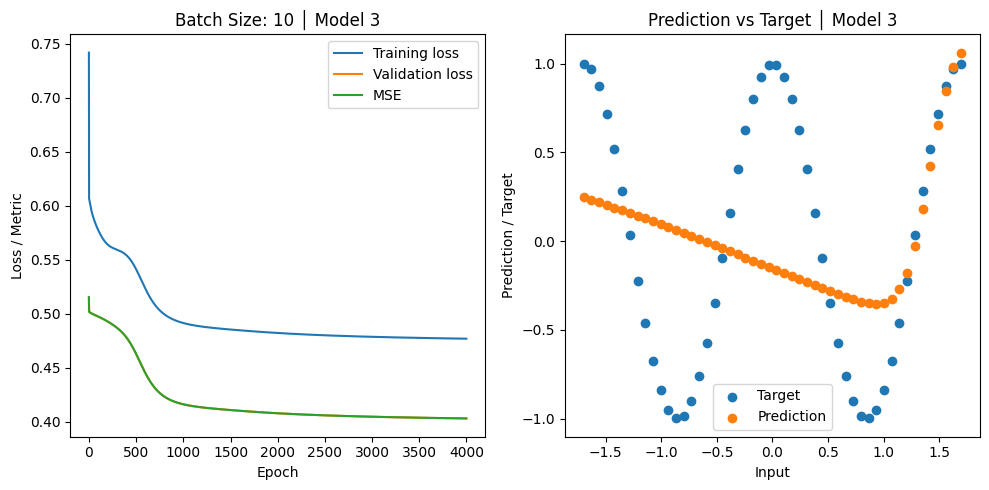


--- Training with Batch Size: 25 & Model 1 ---
Epoch 1       train 0.756938  validation 0.642804  MSE 0.642804
Epoch 1001    train 0.092912  validation 0.091456  MSE 0.091456
Epoch 2001    train 0.033737  validation 0.039303  MSE 0.039303
Epoch 3001    train 0.012417  validation 0.013730  MSE 0.013730
Epoch 4000    train 0.002729  validation 0.002641  MSE 0.002641

** Validation metrics after training **
Loss 0.00264076
MSE 0.00264076

MSE 0.00264076)
Sucessful traing!!!


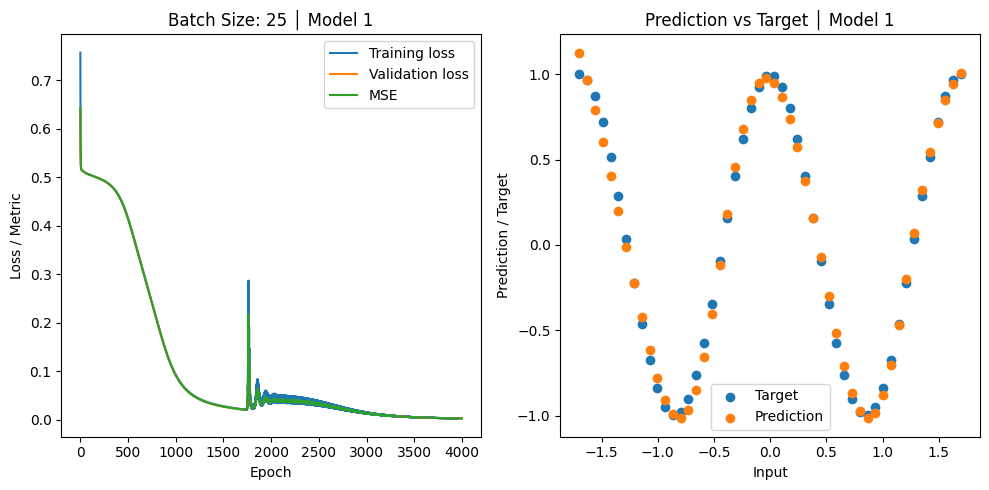


--- Training with Batch Size: 25 & Model 2 ---
Epoch 1       train 0.898050  validation 0.733567  MSE 0.733567
Epoch 1001    train 0.481858  validation 0.481526  MSE 0.481526
Epoch 2001    train 0.463473  validation 0.462977  MSE 0.462977
Epoch 3001    train 0.409045  validation 0.406614  MSE 0.406614
Epoch 4000    train 0.202415  validation 0.202351  MSE 0.202351

** Validation metrics after training **
Loss 0.202351
MSE 0.202351

MSE 0.202351)


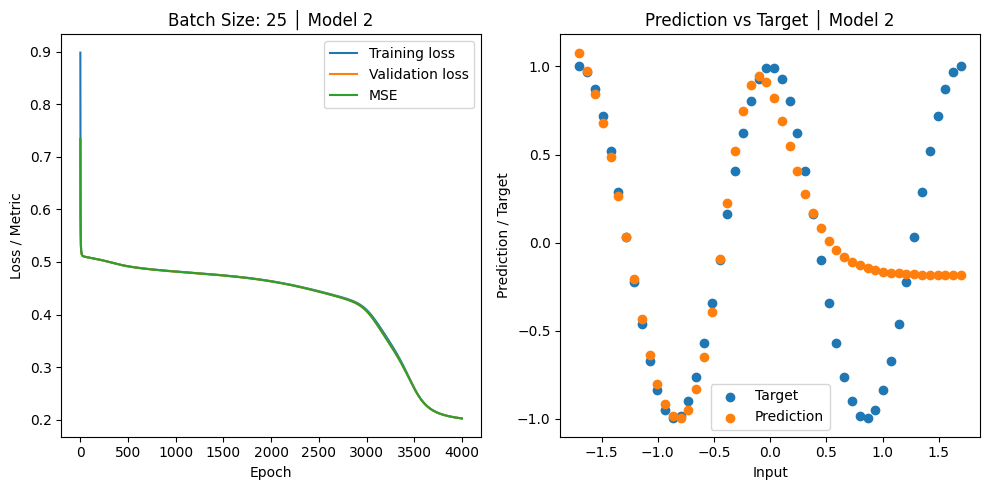


--- Training with Batch Size: 25 & Model 3 ---
Epoch 1       train 0.517158  validation 0.514132  MSE 0.514132
Epoch 1001    train 0.502656  validation 0.502561  MSE 0.502560
Epoch 2001    train 0.446664  validation 0.445651  MSE 0.445651
Epoch 3001    train 0.246773  validation 0.245699  MSE 0.245699
Epoch 4000    train 0.002100  validation 0.002093  MSE 0.002093

** Validation metrics after training **
Loss 0.00209279
MSE 0.00209279

MSE 0.00209279)
Sucessful traing!!!


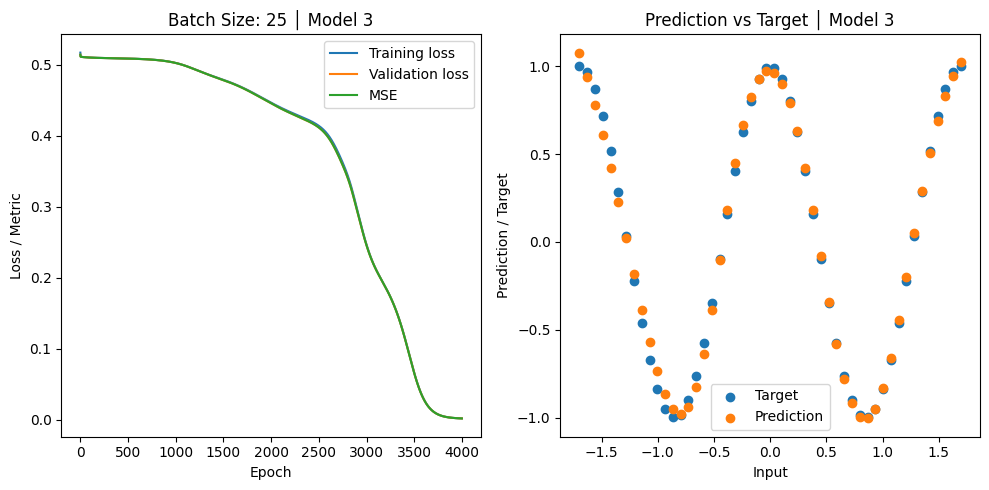


--- Training with Batch Size: 50 & Model 1 ---
Epoch 1       train 0.586314  validation 0.572469  MSE 0.572469
Epoch 1001    train 0.433812  validation 0.433577  MSE 0.433577
Epoch 2001    train 0.239365  validation 0.239276  MSE 0.239276
Epoch 3001    train 0.146041  validation 0.145862  MSE 0.145862
Epoch 4000    train 0.006121  validation 0.006106  MSE 0.006106

** Validation metrics after training **
Loss 0.00610567
MSE 0.00610567

MSE 0.00610567)
Sucessful traing!!!


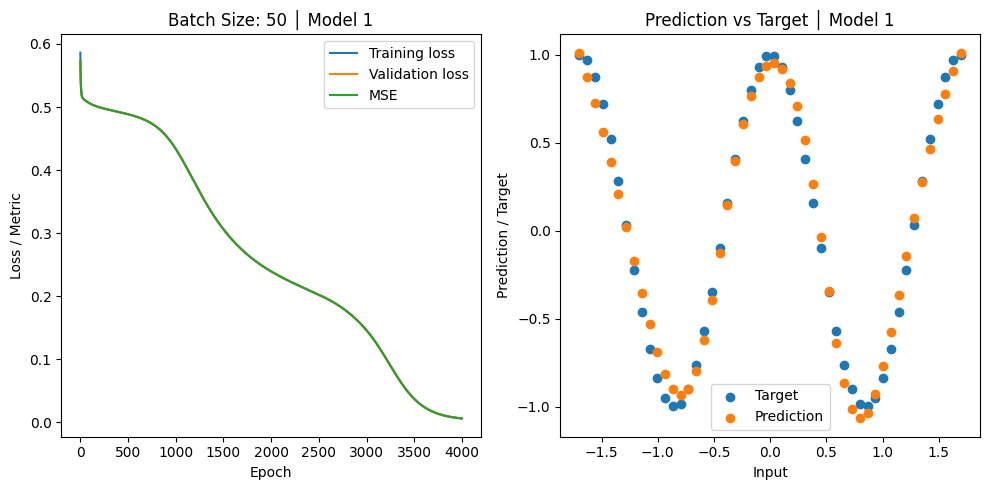


--- Training with Batch Size: 50 & Model 2 ---
Epoch 1       train 0.535445  validation 0.534300  MSE 0.534300
Epoch 1001    train 0.246366  validation 0.245906  MSE 0.245906
Epoch 2001    train 0.010612  validation 0.010589  MSE 0.010589
Epoch 3001    train 0.003044  validation 0.003042  MSE 0.003042
Epoch 4000    train 0.002161  validation 0.002160  MSE 0.002160

** Validation metrics after training **
Loss 0.00216023
MSE 0.00216023

MSE 0.00216023)
Sucessful traing!!!


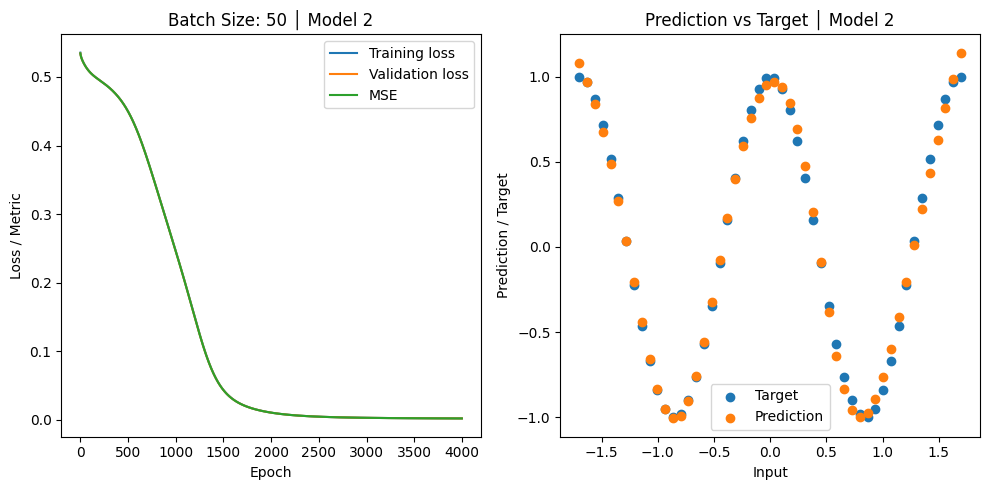


--- Training with Batch Size: 50 & Model 3 ---
Epoch 1       train 0.521468  validation 0.520209  MSE 0.520209
Epoch 1001    train 0.485497  validation 0.485480  MSE 0.485480
Epoch 2001    train 0.468546  validation 0.468525  MSE 0.468525
Epoch 3001    train 0.439199  validation 0.439163  MSE 0.439163
Epoch 4000    train 0.105594  validation 0.104772  MSE 0.104772

** Validation metrics after training **
Loss 0.104772
MSE 0.104772

MSE 0.104772)


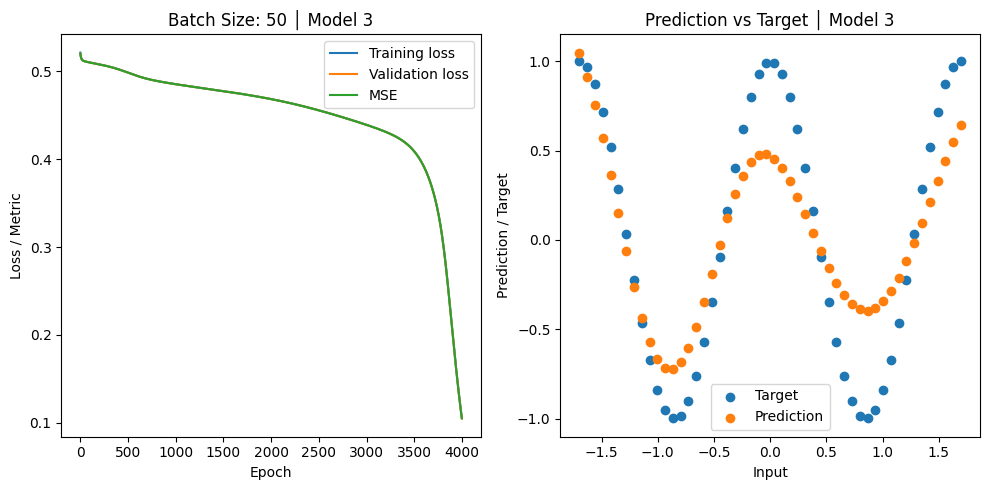

CPU times: user 15min 24s, sys: 883 ms, total: 15min 25s
Wall time: 15min 56s


In [35]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std


# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
# Hyperparameters
batch_size_list = [1, 5, 10, 25, 50]
learning_rate = 0.05

loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
#minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Initialized List of MSEs to Records of metrics
MSEs_bs = {} # record only if MSE < 0.01, i.e. sucessful training


# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                        torch.tensor(d_trn, device=device, dtype=dtype_torch))

for bs in batch_size_list:
  # Define the network, cost function and training settings
  # Initialized List of MSEs to Records of metrics of three runs with the same lr


  for i in range(3):
    # Create a batch loader for the training data
    dl_trn = DataLoader(dset_trn, batch_size=bs)
    model_ex1 = Network(
        inputs=1,            # number of input nodes
        outputs=1,           # number of output nodes
        nodes=[4],           # number of nodes in hidden layer
        activation=nn.Tanh,  # activation function in hidden layer
        out_activation=None  # activation function in output layer (if not linear)
        ).to(device)         # move data to GPU or keep with CPU

    # Set up the optimizer
    optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

    # Print a summary of the model
    print(f"\n--- Training with Batch Size: {bs} & Model {i+1} ---")
    #print(model_ex1)


    # Train the network and print the progress
    train_loss, val_loss, metrics_res = train_loop(
        model=model_ex1,
        train_dataloader=dl_trn,
        val_dataloader=dl_trn, # Test with the training data
        loss_fn=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        print_every=1000,
        epochs=number_epochs)

    # Record performance metrics for MSEs list
    for n, v in metrics_res.items():
      if torch.isreal(v[-1]):
          print(f"{n} {v[-1]:<7g})")
          if v[-1] < 0.01:
            print("Sucessful traing!!!")
            MSEs_bs[f'Batch size {bs} & Model {i+1}'] = v[-1]



    # Predict output on the training data
    d_pred = model_ex1.predict(x_trn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(f"Batch Size: {bs} │ Model {i+1}")
    plot_training(train_loss, val_loss, metrics_res, ax = ax[0])

    ax[1].set_ylabel('Prediction / Target')
    ax[1].set_xlabel('Input')
    ax[1].scatter(x_trn, d_trn, label='Target')
    ax[1].scatter(x_trn, d_pred, label='Prediction')
    ax[1].set_title(f'Prediction vs Target │ Model {i+1}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()



In [37]:
print(MSEs_bs)

{'Batch size 1 & Model 1': tensor(0.0002), 'Batch size 1 & Model 3': tensor(0.0001), 'Batch size 5 & Model 1': tensor(0.0008), 'Batch size 10 & Model 1': tensor(0.0007), 'Batch size 10 & Model 2': tensor(0.0010), 'Batch size 25 & Model 1': tensor(0.0026), 'Batch size 25 & Model 3': tensor(0.0021), 'Batch size 50 & Model 1': tensor(0.0061), 'Batch size 50 & Model 2': tensor(0.0022)}


### Observation for **Question 3**

Batch size 1 is online updating. Consistenly reaches good results with less than 1000 epochs, but it is more computationally expensive.

Batch size 5: training is noisy, with less tendency to converge. With favarable initialization, it can reach very low MSE with 3000-4000 epochs, but sometimes convergence is slower or fails.

Batch size 10 has performance slightly depends on the initial weights. With favarable initialization, it can reach very low MSE with less than 1000 epochs, but sometimes convergence is slower or fails.

Batch size 25 appears to be optimal for this task. Training is stable, convergence is relatively fast with 3000-4000 epochs, and good solutions are reached consistenly.

Batch size 50 is full batch learning. With favarable initialization, it can reach very low MSE with 2000-3000 epochs. Training often fails to reach low MSE, meaning that full batch updates are less effective for this problem.


### Discussion for **Question 3**

Small batch sizes introduce noise into the gradient, which can help escape local minima but may also cause oscillations.

Moderate batch size like 25 gives a good balcne between stability and exploration, leading to faster and more reliable convergence.

Very large batch sizes reudce gradient noise but may get stuck in supoptimal regions, as observed with batch size 50.



##**Question 4**, select good hyper-parameters  

I selected a learning rate 0.05 and a batch size of 1. This combination allows the network to consistenly reach a good solution within 1000 epochs.

In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex1 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[4],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.05          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
minibatch_size = 1

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Print a summary of the model
print(model_ex1)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex1.predict(x_trn)

# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


##**Question 5**, vary epochs  
Compare the number of epochs needed to reach a good solution with that of Q4.  


Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=10, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=10, out_features=1, bias=True)
  )
)
Trainable parameters: 31
Named parameters:
  layer1.weight: 10
  layer1.bias: 10
  layerN.weight: 10
  layerN.bias: 1

Epoch 1       train 0.158756  validation 0.720190  MSE 0.720191
Epoch 101     train 0.167672  validation 0.601603  MSE 0.601603
Epoch 201     train 0.030018  validation 0.087419  MSE 0.087419
Epoch 301     train 0.013680  validation 0.052465  MSE 0.052465
Epoch 401     train 0.009459  validation 0.033353  MSE 0.033353
Epoch 501     train 0.004678  validation 0.021262  MSE 0.021262
Epoch 601     train 0.002986  validation 0.015699  MSE 0.015699
Epoch 701     train 0.002284  validation 0.013185  MSE 0.013185
Epoch 801     train 0.001599  validation 0.010497  MSE 0.010497
Epoch 901     train 0.001212  validation 0.007978  MSE 0.007978
Epoch 1000    train 0.001368  validation 0.006234  M

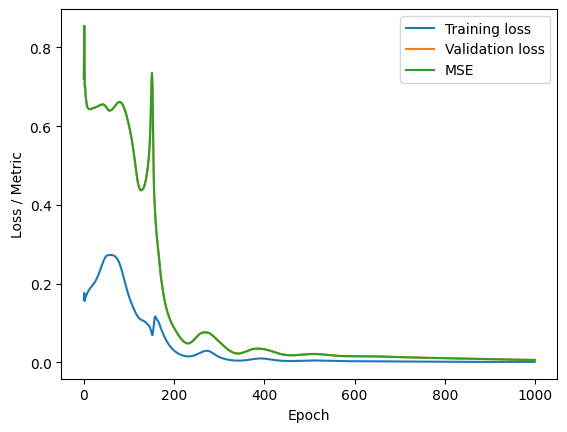

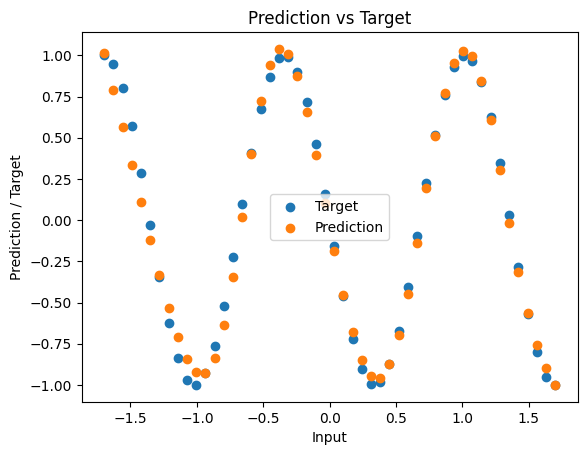

CPU times: user 57.1 s, sys: 53.2 ms, total: 57.1 s
Wall time: 1min 8s


In [7]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
x_trn, d_trn = regr1(50, 2.5, 0, 0.0)

# For Q6:
#x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex2 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[10],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.05          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 1000
minibatch_size = 1

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Print a summary of the model
print(model_ex2)

# Set up the optimizer
optimizer = opt_method(model_ex2.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex2,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex2.predict(x_trn)

# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

##**Question 6**, vary network size and other hyper-parameters  

Network architecture: 4 hidden layers [128,64.32.16]

Mini batch size 32

Learning rate 0.07

Number of epochs 10000

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=128, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=128, out_features=64, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=64, out_features=32, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=32, out_features=16, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=16, out_features=1, bias=True)
  )
)
Trainable parameters: 11137
Named parameters:
  layer1.weight: 128
  layer1.bias: 128
  layer2.weight: 8192
  layer2.bias: 64
  layer3.weight: 2048
  layer3.bias: 32
  layer4.weight: 512
  layer4.bias: 16
  layerN.weight: 16
  layerN.bias: 1

Epoch 1       train 0.163623  validation 0.160062  MSE 0.160062
Epoch 101     train 0.157374  validation 0.157338  MSE 0.157338
Epoch 201     train 0.157305  validation 0.157274  MSE 0.157274
Epoch 301     train 0.157238  validation 0.157208  MSE 0.157208
Epoch 401     train 0.157169  validation 0.157141  MSE 0.1

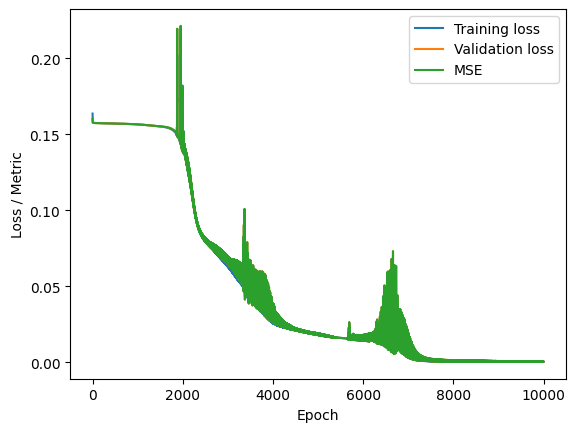

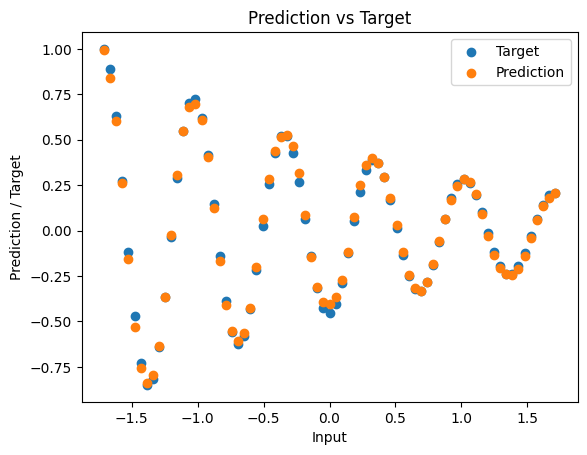

CPU times: user 1min 17s, sys: 139 ms, total: 1min 17s
Wall time: 1min 18s


In [19]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
#x_trn, d_trn = regr1(50, 2.5, 0, 0.0)

# For Q6:
x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

d_mu, d_std = standard(d_trn)
#d_trn = (d_trn - d_mu) / d_std
# Define the network, cost function and training settings
model_ex2 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[128,64,32,16],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.07          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 8000
minibatch_size = 32

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Print a summary of the model
print(model_ex2)

# Set up the optimizer
optimizer = opt_method(model_ex2.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex2,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
#d_pred = model_ex2.predict(x_trn)*d_std + d_mu
d_pred = model_ex2.predict(x_trn)
# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()